In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import torch
import torchvision
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip images randomly
    transforms.RandomRotation(10),  # Slight rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Improve color robustness
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize pixel values
])

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
dataset = ImageFolder('/content/drive/MyDrive/dataset',transform)

Here we begin with the part (a) classification using traditional ML classifiers we use HOG for feature extraction.

In [ ]:
mask_dir = "/content/drive/MyDrive/dataset/with_mask"
no_mask_dir = "/content/drive/MyDrive/dataset/without_mask"
def extract_hog_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features, _ = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                      block_norm='L2-Hys', visualize=True)
    return features

# Function to Load Dataset and Extract Features
def load_dataset():
    X, y = [], []

    for file in os.listdir(mask_dir):
        img_path = os.path.join(mask_dir, file)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (64, 64))
        X.append(extract_hog_features(img))
        y.append(1)  # 1 for 'with mask'

    for file in os.listdir(no_mask_dir):
        img_path = os.path.join(no_mask_dir, file)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (64, 64))
        X.append(extract_hog_features(img))
        y.append(0)  # 0 for 'without mask'

    return np.array(X), np.array(y)

# Load dataset
X, y = load_dataset()

# Standardize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
from sklearn.metrics import classification_report

# Get the number of features for input shape
input_shape = (X_train.shape[1],)  # Dynamically update input shape

# Define ANN Model
ann = models.Sequential([
    layers.Input(shape=input_shape),  # Specify input shape
    layers.Dense(64, activation='relu'),   # First hidden layer
    layers.Dense(32, activation='relu'),   # Second hidden layer
    layers.Dense(2, activation='softmax')  # Output layer for binary classification
])

# Compile the Model
ann.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the Model
ann.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Generate Predictions
y_pred_probs = ann.predict(X_test)  # Get predicted probabilities
y_pred = y_pred_probs.argmax(axis=1)  # Convert to class labels

# Print Classification Report
print(classification_report(y_test, y_pred))


SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define Hyperparameter Grid for SVM
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.01, 0.1]
}

# Perform GridSearchCV to Find Best SVM Parameters
svm_clf = GridSearchCV(SVC(), param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
svm_clf.fit(X_train, y_train)

# Predict using Best SVM Model
y_pred_svm = svm_clf.best_estimator_.predict(X_test)

# Print Classification Report
print(classification_report(y_test, y_pred_svm))


Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define Hyperparameter Grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [None, 10, 20],     # Maximum depth of trees
    'min_samples_split': [2, 5, 10], # Minimum samples required to split
    'min_samples_leaf': [1, 2, 4]    # Minimum samples per leaf
}

# Perform GridSearchCV to Find Best Parameters
rf_clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
rf_clf.fit(X_train, y_train)

# Predict using Best Random Forest Model
y_pred_rf = rf_clf.best_estimator_.predict(X_test)

# Print Classification Report
print(classification_report(y_test, y_pred_rf))


In [5]:
img,label = dataset[0]
print(img.shape,label)
img

torch.Size([3, 224, 224]) 0


tensor([[[-1.0000, -1.0000, -1.0000,  ...,  0.4118, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ...,  0.4118, -1.0000, -1.0000],
         [ 0.5373,  0.5294,  0.5294,  ...,  0.3961, -1.0000, -1.0000],
         ...,
         [-1.0000, -1.0000, -0.9922,  ...,  0.1294,  0.6235,  0.6627],
         [-1.0000, -1.0000, -0.9686,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -0.9765,  ..., -1.0000, -1.0000, -1.0000]],

        [[-1.0000, -1.0000, -1.0000,  ...,  0.5922, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ...,  0.5843, -1.0000, -1.0000],
         [ 0.6549,  0.6627,  0.6627,  ...,  0.5843, -1.0000, -1.0000],
         ...,
         [-1.0000, -1.0000, -1.0000,  ...,  0.2078,  0.7098,  0.7333],
         [-1.0000, -1.0000, -0.9765,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -0.9922,  ..., -1.0000, -1.0000, -1.0000]],

        [[-1.0000, -1.0000, -1.0000,  ...,  0.6471, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ...,  0

In [6]:
print(dataset.classes)

['with_mask', 'without_mask']


label: with_mask (0)


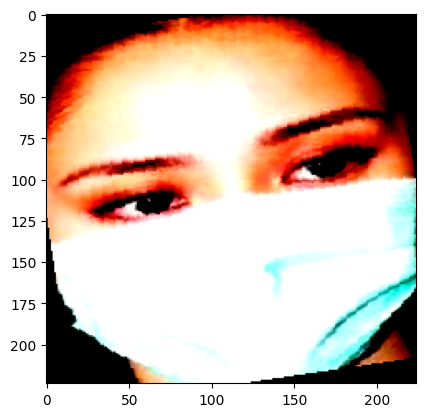

In [7]:
import matplotlib.pyplot as plt
def show_example(img,label):
    print('label:',dataset.classes[label],"("+str(label)+")")
    plt.imshow(img.permute(1,2,0)) #moving the channel because matplotlib requried the first feild to be the channel

show_example(*dataset[10])

In [8]:
random_seed = 42
torch.manual_seed(random_seed)

In [9]:
from torch.utils.data import random_split, DataLoader

# Define split sizes
test_size = int(0.1 * len(dataset))   # 10% for test
val_size = int(0.1 * len(dataset))    # 10% for validation
train_size = len(dataset) - test_size - val_size  # Remaining 80% for training

# Perform the split
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# Define DataLoaders
batch_size = 32
# batch_size=128

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=10, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=batch_size * 2, num_workers=10, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=batch_size * 2, num_workers=10, pin_memory=True)

# Check lengths
print(len(train_ds), len(val_ds), len(test_ds))


3276 409 409


In [10]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images,labels in dl:
        fig,ax = plt.subplots(figsize=(12,6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

In [11]:
# show_batch(train_dl)

In [12]:
import torch.nn as nn
import torch.nn.functional as F

# simple_model = nn.Sequential(
#     nn.Conv2d(3,8,kernel_size=3,stride=1,padding=1),
#     nn.MaxPool2d(2,2)
# )
# for images,labels in train_dl:
#     print('images.shape:',images.shape)
#     out = simple_model(images)
#     print('out.shape:',out.shape)
#     break

In [13]:
class ImageClassificationBase(nn.Module):
    def training_step(self,batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        return loss
    def validation_step(self,batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        acc = accuracy(out,labels)
        return {'val_loss':loss.detach(),'val_acc':acc}
    def validation_epoch_end(self,outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}
    def epoch_end(self,epoch,result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch,result['val_loss'],result['val_acc']))

def accuracy(outputs,labels):
    _,preds = torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))


In [14]:
class MyCNN(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3,padding=1),
            nn.ReLU(),
            # nn.GELU(),
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            # nn.GELU(),
            nn.MaxPool2d(2,2), #output: 64 x 16 x 16
            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            # nn.GELU(),
            nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            # nn.GELU(),
            nn.MaxPool2d(2,2), #output: 128 x 8 x 8
            nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            # nn.GELU(),
            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            # nn.GELU(),
            nn.MaxPool2d(2,2), #output: 256 x 4 x 4
            nn.Flatten(),
            nn.Linear(256*28*28,1024),
            nn.ReLU(),
            # nn.GELU(),
            nn.Linear(1024,512),
            nn.ReLU(),
            # nn.GELU(),
            nn.Linear(512,2)

        )
    def forward(self,xb):
        return self.network(xb)

In [15]:
model  = MyCNN()

In [16]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)
    def __len__(self):
        return len(self.dl)

In [17]:
device = get_default_device()
device

device(type='cuda')

In [18]:
train_dl = DeviceDataLoader(train_dl,device)
val_dl = DeviceDataLoader(val_dl,device)
test_dl = DeviceDataLoader(test_dl,device)
to_device(model,device)


MyCNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=200704, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=102

Training the Model


In [19]:
from matplotlib.pyplot import hist


@torch.no_grad()
def evaluate(model,val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs,lr,model,train_loader,val_loader,opt_func):
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model,val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch,result)
        history.append(result)
    return history

In [20]:
model = to_device(MyCNN(),device)


In [21]:
evaluate(model,val_dl)

{'val_loss': 0.6938956379890442, 'val_acc': 0.48026785254478455}

In [22]:
num_epochs = 10
opt_func = torch.optim.Adam
lr=0.0001

In [23]:
history = fit(num_epochs,lr,model,train_dl,val_dl,opt_func)

Epoch [0], val_loss: 0.2140, val_acc: 0.9171
Epoch [1], val_loss: 0.1770, val_acc: 0.9293
Epoch [2], val_loss: 0.1597, val_acc: 0.9496
Epoch [3], val_loss: 0.1382, val_acc: 0.9496
Epoch [4], val_loss: 0.1464, val_acc: 0.9519
Epoch [5], val_loss: 0.1578, val_acc: 0.9439
Epoch [6], val_loss: 0.1666, val_acc: 0.9395
Epoch [7], val_loss: 0.1433, val_acc: 0.9474
Epoch [8], val_loss: 0.1255, val_acc: 0.9563
Epoch [9], val_loss: 0.1240, val_acc: 0.9529


In [24]:
test_loader = DeviceDataLoader(test_dl,device)
result = evaluate(model,test_loader)
result

{'val_loss': 0.07719188183546066, 'val_acc': 0.9776785969734192}

[{'val_loss': 0.21396204829216003, 'val_acc': 0.9171428680419922, 'train_loss': 0.4087701141834259}, {'val_loss': 0.1770254671573639, 'val_acc': 0.9292857050895691, 'train_loss': 0.23995019495487213}, {'val_loss': 0.1597430408000946, 'val_acc': 0.9496428370475769, 'train_loss': 0.19086854159832}, {'val_loss': 0.13822342455387115, 'val_acc': 0.9496428370475769, 'train_loss': 0.1794041395187378}, {'val_loss': 0.14640465378761292, 'val_acc': 0.9518750309944153, 'train_loss': 0.17528843879699707}, {'val_loss': 0.15783977508544922, 'val_acc': 0.943928599357605, 'train_loss': 0.1423737108707428}, {'val_loss': 0.1665683537721634, 'val_acc': 0.939464271068573, 'train_loss': 0.15133950114250183}, {'val_loss': 0.14332763850688934, 'val_acc': 0.9474107027053833, 'train_loss': 0.1442403495311737}, {'val_loss': 0.12552449107170105, 'val_acc': 0.9563392996788025, 'train_loss': 0.1175546944141388}, {'val_loss': 0.12400641292333603, 'val_acc': 0.9528571367263794, 'train_loss': 0.1119542270898819}]


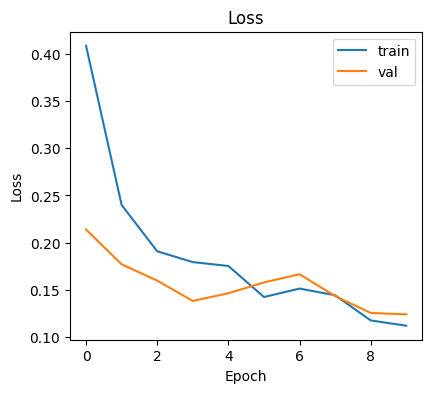

In [25]:
print(history)
train_losses = []
val_losses = []
val_accuracy = []
for i in history:
  train_losses.append(i['train_loss'])
  val_losses.append(i['val_loss'])
  val_accuracy.append(i['val_acc'])
# Plot the losses
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

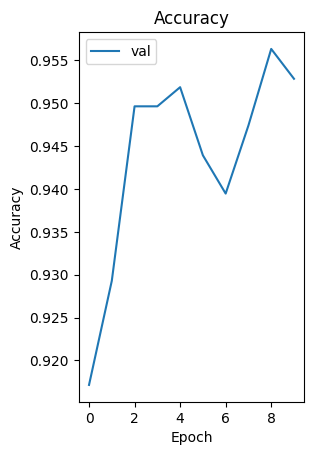

In [26]:

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.plot(val_accuracy, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()